# Testing wind stress curl performance 

Does the interpolation of the wind from coarse to fine grid appropriate? Are there any large gradients that mess up the wind stress curl (and hence Ekman upwelling) in some areas? 
https://github.com/ACCESS-NRI/model_configuration/issues/2



In [17]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.gridspec as gridspec
%matplotlib inline

import xgcm

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43763/status,
Dashboard: /proxy/43763/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44921,Workers: 7
Dashboard: /proxy/43763/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:45845,Total threads: 4
Dashboard: /proxy/35241/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:46085,


In [3]:
# CM2 database
session_CM2 = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
expt_CM2_1   = 'bz687'

In [62]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_bgc'#'025deg_jra55_ryf9091_gadi'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

In [4]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

### Important wind stress for a region in the Southern Ocean

In [6]:
# Same region as in this notebook: https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Geostrophic_Velocities_from_Sea_Level.ipynb
lon_lim = slice(-224.2, -212)
lat_lim = slice(-53.5, -47.5)

In [63]:
start_time = '0499-01-01'
end_time   = '0499-12-31'

OM2_start = '2099-01-01'
OM2_end   = '2099-12-31'

Load wind stress for CM2 and OM2, 025 grid

In [ ]:
taux_CM2_025 = cc.querying.getvar(expt_CM2_025, variable='tau_x', 
                          session=session_CM2, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time=start_time, 
                          end_time=end_time)
taux_CM2_025 = taux_CM2_025.sel(time=slice(start_time, end_time))
taux_CM2_025 = taux_CM2_025.sel(xu_ocean=lon_lim).sel(yu_ocean=lat_lim)

tauy_CM2_025 = cc.querying.getvar(expt_CM2_025, variable='tau_y', 
                          session=session_CM2, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time=start_time, 
                          end_time=end_time)
tauy_CM2_025 = tauy_CM2_025.sel(time=slice(start_time, end_time))
tauy_CM2_025 = tauy_CM2_025.sel(xu_ocean=lon_lim).sel(yu_ocean=lat_lim)

In [80]:
taux_OM2_025 = cc.querying.getvar(expt_OM2_025, variable='tau_x', 
                          session=session_OM2, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time=OM2_start, 
                          end_time=OM2_end, use_cftime=True)
taux_OM2_025 = taux_OM2_025.sel(time=slice(OM2_start, OM2_end))
taux_OM2_025 = taux_OM2_025.sel(xu_ocean=lon_lim).sel(yu_ocean=lat_lim)[0,...]

tauy_OM2_025 = cc.querying.getvar(expt_OM2_025, variable='tau_y', 
                          session=session_OM2, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time=OM2_start, 
                          end_time=OM2_end, use_cftime=True)
tauy_OM2_025 = tauy_OM2_025.sel(time=slice(OM2_start, OM2_end))
tauy_OM2_025 = tauy_OM2_025.sel(xu_ocean=lon_lim).sel(yu_ocean=lat_lim)[0,...]

In [78]:
taux_CM2_025

<xarray.DataArray 'tau_x' (time: 12, yu_ocean: 38, xu_ocean: 49)>
dask.array<getitem, shape=(12, 38, 49), dtype=float32, chunksize=(1, 38, 49), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -224.0 -223.8 -223.5 ... -212.5 -212.2 -212.0
  * yu_ocean  (yu_ocean) float64 -53.46 -53.31 -53.16 ... -47.93 -47.76 -47.59
  * time      (time) object 0499-01-16 12:00:00 ... 0499-12-16 12:00:00
Attributes: (12/13)
    long_name:      i-directed wind stress forcing u-velocity
    units:          N/m^2
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    ...             ...
    ncfiles:        ['/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/o...
    contact:        Martin Dix
    email:          martin.dix@csiro.au
    created:        2021-11-30
    description:    ACCESS-CM2 with n96 atmosphere coupled to COSIMA OM2 0.25...
    url:            https://code.metoffice.gov.uk/svn/roses-u/c/j/8/7/7/trunk

In [82]:
# Create xgcm grid
folder = '/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords')

# CM2-025
ds_CM2_025 = xr.merge([taux_CM2_025, tauy_CM2_025, grid])
ds_CM2_025.coords['xt_ocean'].attrs.update(axis='X')
ds_CM2_025.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds_CM2_025.coords['yt_ocean'].attrs.update(axis='Y')
ds_CM2_025.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
grid_CM2_025 = xgcm.Grid(ds_CM2_025, periodic=['X'])

# OM2-025
ds_OM2_025 = xr.merge([taux_OM2_025, tauy_OM2_025, grid])
ds_OM2_025.coords['xt_ocean'].attrs.update(axis='X')
ds_OM2_025.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds_OM2_025.coords['yt_ocean'].attrs.update(axis='Y')
ds_OM2_025.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
grid_OM2_025 = xgcm.Grid(ds_OM2_025, periodic=['X'])

In [66]:
grid_CM2_025

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

In [67]:
ds_CM2_025

<xarray.Dataset>
Dimensions:     (xu_ocean: 1440, yu_ocean: 1080, time: 13, xt_ocean: 1440,
                 yt_ocean: 1080)
Coordinates:
  * xu_ocean    (xu_ocean) float64 -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yu_ocean    (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
  * time        (time) object 0499-01-16 12:00:00 ... 1959-12-30
  * xt_ocean    (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean    (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    geolon_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    geolat_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    geolon_c    (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    geolat_c    (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
Data variables: (12/13)
    tau_x       (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    tau_y       (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    ht          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    hu          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ...          ...
    dyu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    drag_coeff  (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(13, 1080, 1440), meta=np.ndarray>
Attributes: (12/13)
    long_name:      i-directed wind stress forcing u-velocity
    units:          N/m^2
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    ...             ...
    ncfiles:        ['/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/o...
    contact:        Martin Dix
    email:          martin.dix@csiro.au
    created:        2021-11-30
    description:    ACCESS-CM2 with n96 atmosphere coupled to COSIMA OM2 0.25...
    url:            https://code.metoffice.gov.uk/svn/roses-u/c/j/8/7/7/trunk

In [69]:
dtauy_dx_CM2_025 = grid_CM2_025.interp( grid_CM2_025.diff(ds_CM2_025.tau_y, 'X') / grid_CM2_025.interp(ds_CM2_025.dxu, 'X'), 'Y', boundary='extend')
dtaux_dy_CM2_025 = grid_CM2_025.interp( grid_CM2_025.diff(ds_CM2_025.tau_x, 'Y', boundary='extend') / grid_CM2_025.interp(ds_CM2_025.dyt, 'X'), 'X')

curl_CM2_025 = dtauy_dx_CM2_025 - dtaux_dy_CM2_025

curl_CM2_025 = curl_CM2_025.rename('Wind stress curl')
curl_CM2_025 = curl_CM2_025.sel(xt_ocean=lon_lim).sel(yt_ocean=lat_lim).sel(time=slice(start_time, end_time))

In [85]:
dtauy_dx_OM2_025 = grid_OM2_025.interp( grid_OM2_025.diff(ds_OM2_025.tau_y, 'X') / grid_OM2_025.interp(ds_OM2_025.dxu, 'X'), 'Y', boundary='extend')
dtaux_dy_OM2_025 = grid_OM2_025.interp( grid_OM2_025.diff(ds_OM2_025.tau_x, 'Y', boundary='extend') / grid_OM2_025.interp(ds_OM2_025.dyt, 'X'), 'X')

curl_OM2_025 = dtauy_dx_OM2_025 - dtaux_dy_OM2_025

curl_OM2_025 = curl_OM2_025.rename('Wind stress curl')
curl_OM2_025 = curl_OM2_025.sel(xt_ocean=lon_lim).sel(yt_ocean=lat_lim)#.sel(time=slice(start_time, end_time))

Text(0, 0.5, '')

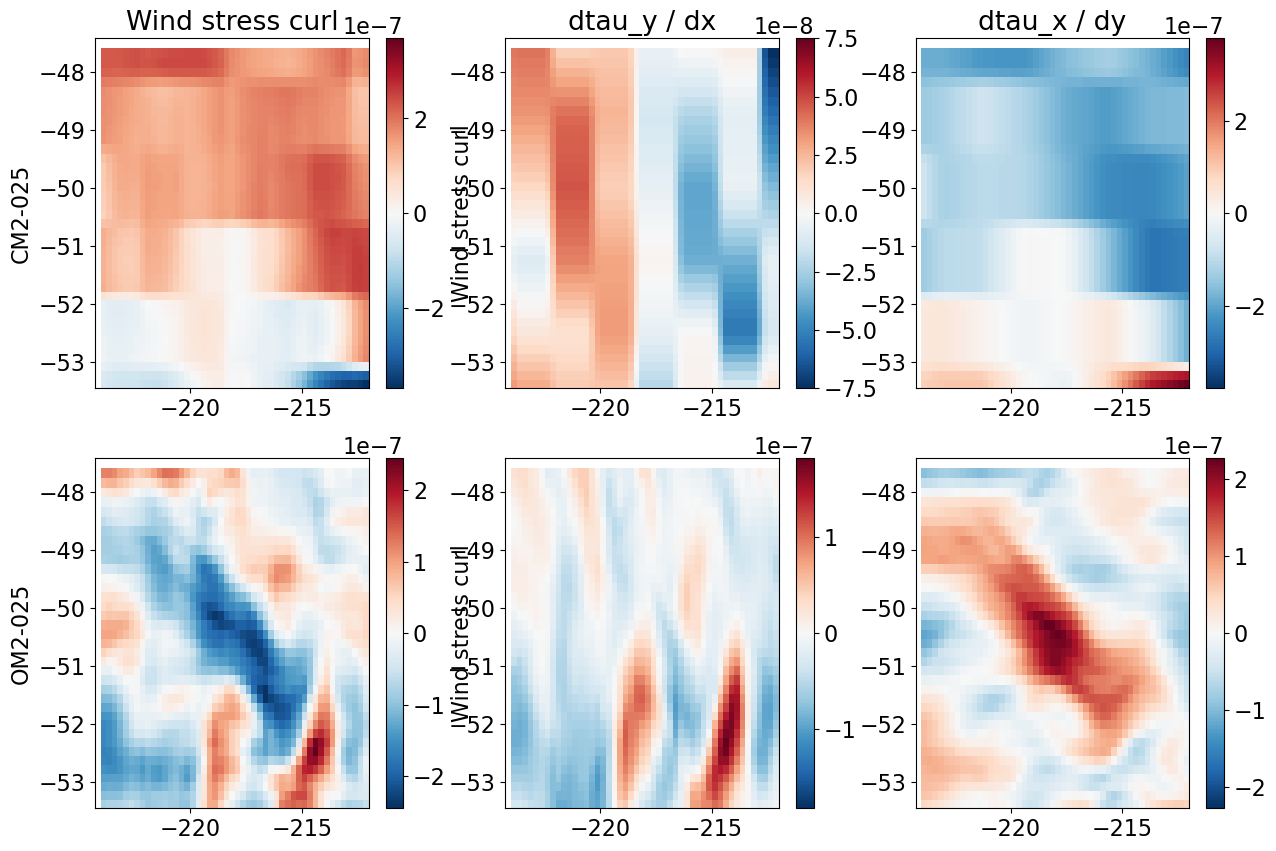

In [107]:
fig = plt.figure(figsize=(15,10))

plt.subplot(231)
curl_CM2_025[0,...].plot()
plt.ylabel('CM2-025')
plt.xlabel('')
plt.title('Wind stress curl')

plt.subplot(232)
dtauy_dx_CM2_025.sel(xt_ocean=lon_lim).sel(yt_ocean=lat_lim)[0,...].plot()
plt.ylabel('')
plt.xlabel('')
plt.title('dtau_y / dx')

plt.subplot(233)
dtaux_dy_CM2_025.sel(xt_ocean=lon_lim).sel(yt_ocean=lat_lim)[0,...].plot()
plt.ylabel('')
plt.xlabel('')
plt.title('dtau_x / dy')

plt.subplot(234)
curl_OM2_025.plot()
plt.ylabel('OM2-025')
plt.xlabel('')

plt.subplot(235)
dtauy_dx_OM2_025.sel(xt_ocean=lon_lim).sel(yt_ocean=lat_lim).plot()
plt.xlabel('')
plt.ylabel('')

plt.subplot(236)
dtaux_dy_OM2_025.sel(xt_ocean=lon_lim).sel(yt_ocean=lat_lim).plot()
plt.xlabel('')
plt.ylabel('')

Text(0.5, 1.0, 'tauy')

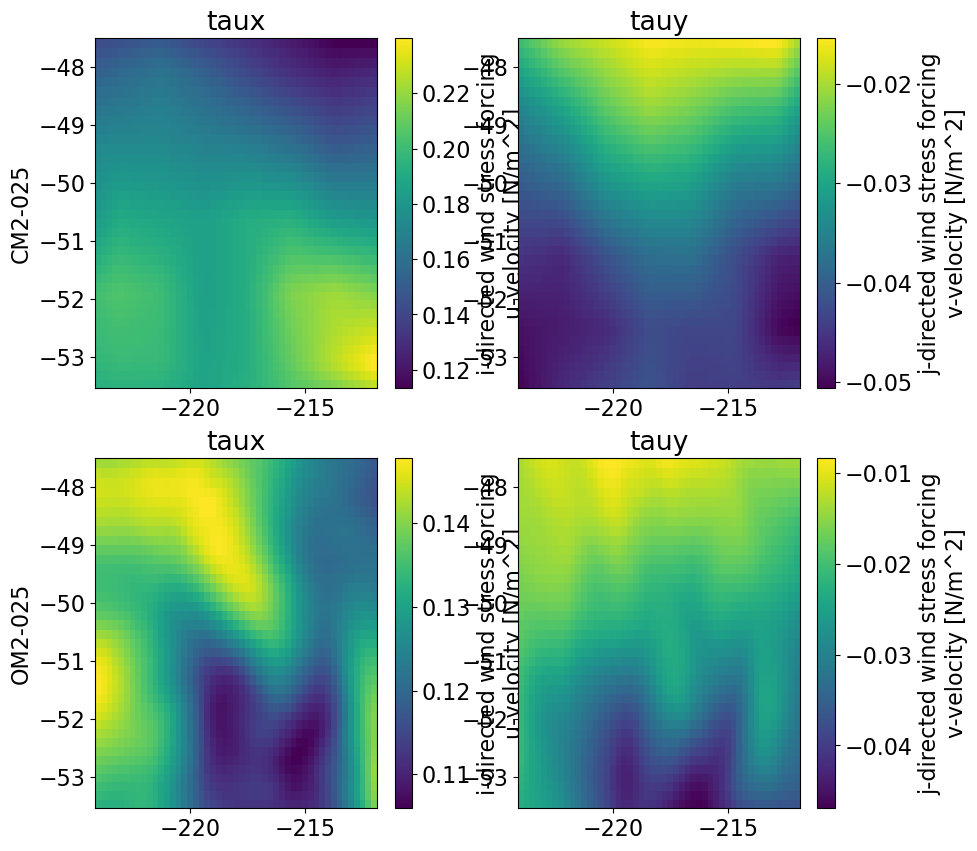

In [109]:
fig = plt.figure(figsize=(10,10))

plt.subplot(221)
taux_CM2_025[0,...].plot()
plt.ylabel('CM2-025')
plt.xlabel('')
plt.title('taux')

plt.subplot(222)
tauy_CM2_025[0,...].plot()
plt.ylabel('')
plt.xlabel('')
plt.title('tauy')

plt.subplot(223)
taux_OM2_025.plot()
plt.ylabel('OM2-025')
plt.xlabel('')
plt.title('taux')

plt.subplot(224)
tauy_OM2_025.plot()
plt.ylabel('')
plt.xlabel('')
plt.title('tauy')